In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import math as mt
from sklearn import preprocessing

Func to fix the columns of the dataframe

In [4]:
def getColumns(size):
    columns = []
    for i in range(size):
        columns.append(i)
    return columns

Load the CMAPSS dataset

In [5]:
directory = "./CMAPSSData/train_FD001.txt"
turbo = pd.read_csv(directory, header=None, sep=' ')
turbo = turbo.drop([26, 27], axis=1)

Drop the input variable columns, the simulation number and the cycle number columns

In [6]:
# Drop the input parameters to get just the sensors
turboSens = turbo.drop([0,1,2,3,4], axis=1)
turboSens.columns = getColumns(turboSens.shape[1])

Drop the columns which never change values

In [7]:
# Get the cycles and useful sensors. 
turboUsefulSens = turboSens.drop([0, 9, 17, 18], axis=1)

Create scalers to normalise or standardise the data

In [8]:
min_max_scaler = preprocessing.MinMaxScaler()
norm_sens = min_max_scaler.fit_transform(turboUsefulSens)

standard = preprocessing.StandardScaler()
std_sens = standard.fit_transform(turboUsefulSens)

Get the cycle column to be used as the labels
The row values are flipped to become remaining useful life
(ie. if cycle number is 100 and the simulation ran for 150 cycles, the RUL label would be 50)

In [10]:
turboCycles = turbo[1]
deteriorate = []
maxCycle = float(turboCycles.max())

In [11]:
currentCount = maxCycle
for i in range(turbo.shape[0] - 1, -1, -1):
    currentRow = turboCycles.loc[i]
    deteriorate.insert(0, currentCount)
    if currentRow == 1:
        currentCount = maxCycle
    else:
        currentCount -= 1

In [12]:
deteriorate = pd.DataFrame(deteriorate)

In [13]:
deteriorateSwap = []
for i in deteriorate[0]:
    deteriorateSwap.append(maxCycle - i)
deteriorate = pd.DataFrame(deteriorateSwap)


Join the data temporarily to randomise it then seperate it

In [14]:
norm_sens = pd.DataFrame(norm_sens)
deteriorate = deteriorate.join(norm_sens, lsuffix='0', rsuffix='1')

deteriorate = deteriorate.sample(frac=1)

deteriorate.columns = getColumns(deteriorate.shape[1])

In [15]:
norm_sens = deteriorate.drop(0, axis=1)
norm_sens = norm_sens.to_numpy()
deteriorate = deteriorate[0].to_numpy()

Creating the model, compiling it and calling the fit function. The data has an 80/20 train/validation split

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [17]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss='mse', 
              metrics=['mae'])

In [18]:
history = model.fit(norm_sens, deteriorate, epochs=50, validation_split = 0.2, verbose=1)

Train on 16504 samples, validate on 4127 samples
Epoch 1/50
16504/16504 [==============================] - 1s 86us/sample - loss: 5786.4022 - mae: 58.4789 - val_loss: 2168.7871 - val_mae: 34.7800
Epoch 2/50
16504/16504 [==============================] - 1s 36us/sample - loss: 2021.2516 - mae: 33.6559 - val_loss: 1978.6758 - val_mae: 33.2874
Epoch 3/50
16504/16504 [==============================] - 1s 36us/sample - loss: 1921.9192 - mae: 32.4582 - val_loss: 1919.7707 - val_mae: 32.4990
Epoch 4/50
16504/16504 [==============================] - 1s 36us/sample - loss: 1876.9373 - mae: 31.8823 - val_loss: 1887.9432 - val_mae: 32.0570
Epoch 5/50
16504/16504 [==============================] - 1s 34us/sample - loss: 1853.3026 - mae: 31.4836 - val_loss: 1870.2035 - val_mae: 31.8779
Epoch 6/50
16504/16504 [==============================] - 1s 35us/sample - loss: 1837.2291 - mae: 31.2861 - val_loss: 1860.8399 - val_mae: 31.4531
Epoch 7/50
16504/16504 [==============================] - 1s 38us/sam

Plot the graph of the model training over time

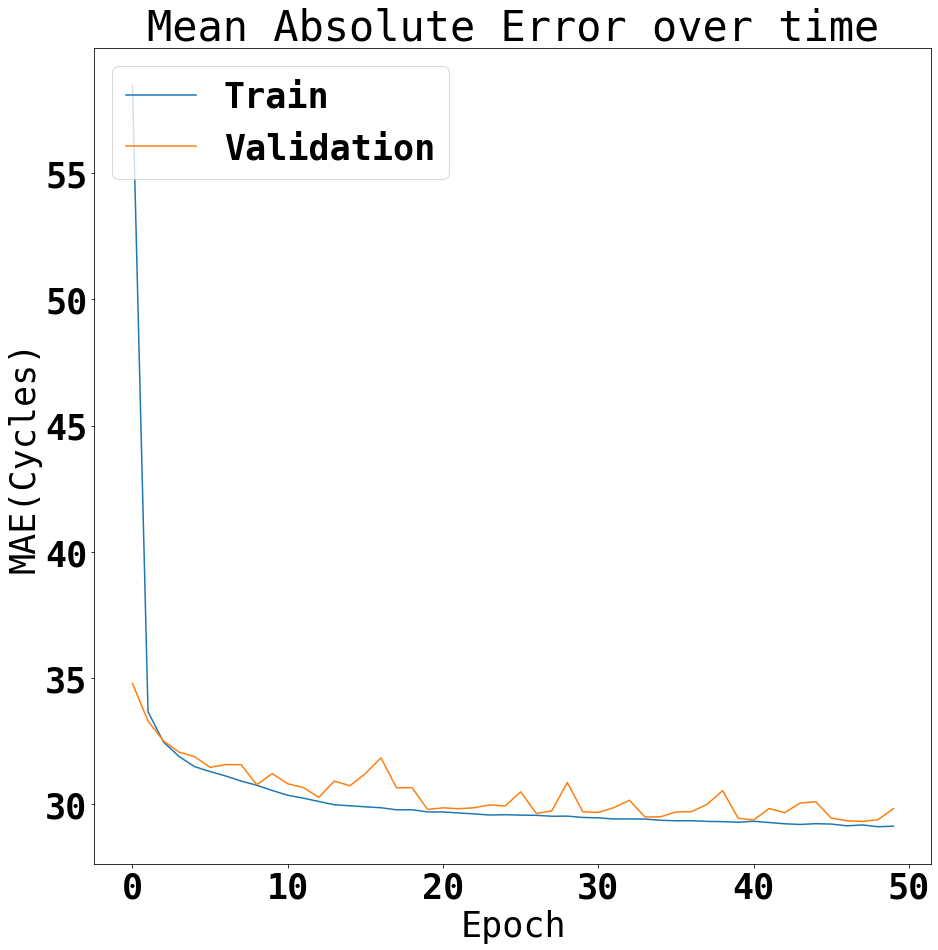

In [22]:
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error over time')
plt.ylabel('MAE(Cycles)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 35}

matplotlib.rc('font', **font)



plt.savefig('InitialExample.png',  bbox_inches='tight')